# Programmierabgabe - Gruppe 10
**Teilnehmer der Gruppe:**
- Bergmann, Jona (2950692)
- Busch, Henrik (9308097)

Für die Lösung dieser Aufgabe wurde ein `Python 3.10.12 Kernel` verwendet. Alle formalen Anforderungen an diese Prüfungsleistung sind in diesem Jupyter-Notebook vorhanden. Als IDE für die Erstellung des Notebooks wurde `VS Code` auf `Windows 10` genutzt.


## Klassifikation von Objekten in Bildern mit Deep Learning mit Tensorflow
Klassifiziert werden, sollen zehn Objekte des Datensets `CIFAR10`. Die folgenden Objekte sind:

1. Flugzeug
2. Auto
3. Vogel
4. Katze
5. Reh
6. Hund
7. Frosch
8. Pferd
9. Schiff
10. LKW

### Merkmalsbasierte Klassifikation
Die gestellte Aufgabe dieses Teils der Prüfunsgleistung sieht vor, dass `Deep Learning` zur Objekt-Klassifikation genutzt werden soll.

In [46]:
pip install numpy matplotlib scikit-learn tensorflow-cpu tf-keras-vis

Note: you may need to restart the kernel to use updated packages.


In [47]:
# Standard-Bibliotheken
import os
import pickle

# Datenverarbeitung und Visualisierung
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# TensorFlow und Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical





# Verarbeitung des CIFAR-10-Datensatzes
- Laden des CIFAR-10-Datensatzes mit Hilfe von Pickle
- Trainings- und Testdaten werden zusammengeführt. Dies muss gemacht werden, da die Daten in Trainings- und Testdaten gespalten sind. Weil aber später ein 75:25 Split verwendet werden soll, werden diese zusammengeführt
- Die Wertebereiche der Bilddaten werden von [0, 255] auf [0, 1] reduziert


In [48]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(len(X), 3, 32, 32).transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y


def load_cifar10_data(data_dir):
    train_files = [os.path.join(data_dir, 'data_batch_{}'.format(i)) for i in range(1,6)]
    
    X_train = []
    Y_train = []
    
    for file in train_files:
        X, Y = load_cifar_batch(file)
        X_train.append(X)
        Y_train.append(Y)
    
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    
    X_test, Y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    
    return X_train, Y_train, X_test, Y_test

data_dir = './cifar-10-batches-py'

X_train, Y_train, X_test, Y_test = load_cifar10_data(data_dir)

# Kombinieren der ursprünglichen Trainings- und Testdaten
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

print('Gesamtdaten:', X.shape, Y.shape)

# Normalisierung der Bilddaten auf den Bereich [0, 1]
X = X.astype('float32') / 255.0

print('Nach Normalisierung:', X.min(), X.max())

Gesamtdaten: (60000, 32, 32, 3) (60000,)
Nach Normalisierung: 0.0 1.0


# Erklärung der Netzwerkarchitektur für die Klassifikationsaufgabe

Die vorgestellte Convolutional Neural Network (CNN)-Architektur wurde speziell für die Klassifikation von CIFAR-10-Daten erstellt. CIFAR-10 besteht aus 32x32 RGB-Bildern, die in 10 Klassen unterteilt sind. Das Modell wurde entworfen, um Merkmale effizient zu extrahieren und die Generalisierungsfähigkeit auf die Testdaten zu maximieren. Nachfolgend wird die Architektur detailliert beschrieben und begründet.

---

## **Netzwerkarchitektur**

### **Convolutional Block 1**
- **Ziel**: Erfassen von lokalen Merkmalen wie Kanten und Texturen in den Eingabebildern.
- **Details**:
  - **2D-Convolutional-Schichten (`Conv2D`)**:
    - Verwenden eines 3x3-Filters, um kleine, lokale Merkmale zu extrahieren.
    - Aktivierungsfunktion `ReLU`: Führt zur sparsamen Aktivierung und verhindert den Vanishing-Gradient.
    - Padding = `'same'`: Bewahrt die räumliche Dimension (32x32 Pixel) der Bilder.
  - **MaxPooling-Schicht (`MaxPooling2D`)**:
    - Reduziert die räumlichen Dimensionen (von 32x32 auf 16x16), um Rechenaufwand zu minimieren und Translationen zu berücksichtigen.
  - **Dropout-Schicht (`Dropout`)**:
    - Entfernt zufällig 25% der Neuronen während des Trainings, um Overfitting zu verhindern.

---

### **Convolutional Block 2**
- **Ziel**: Erfassen komplexerer und abstrakterer Merkmale (z. B. Objekte und Strukturen).
- **Details**:
  - **Erhöhte Anzahl von Filtern (64)**:
    - Die Anzahl der Filter wurde verdoppelt, um komplexere Merkmale zu lernen.
  - **MaxPooling und Dropout**:
    - Ähnliche Funktionen wie im ersten Block, jedoch auf höherem Abstraktionsniveau (reduziert Dimension von 16x16 auf 8x8).

---

### **Fully Connected Layers**
- **Ziel**: Klassifizieren der extrahierten Merkmale in die 10 CIFAR-10-Klassen.
- **Details**:
  - **Flatten-Schicht**:
    - Konvertiert die 8x8x64-Ausgabe der Convolutional-Schichten in einen 1D-Vektor (Features).
  - **Dense-Schicht (512 Neuronen)**:
    - Vollständig verbundene Schicht mit ReLU-Aktivierung für komplexe Merkmalskombinationen.
  - **Dropout-Schicht (50%)**:
    - Hoher Dropout-Wert, um Overfitting zu reduzieren.
  - **Ausgangsschicht**:
    - `Dense(10, activation='softmax')`: Gibt Wahrscheinlichkeiten für jede der 10 Klassen aus.


In [49]:
def create_cnn_model():
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    #model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model


model = create_cnn_model()

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,274 (2.26 MB)

 Trainable params: 591,274 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

# Auswahl der Loss-Funktion und des Optimizers

## 1. **Loss-Funktion**: `sparse_categorical_crossentropy`

Die **Loss-Funktion** misst die Differenz zwischen den vorhergesagten Wahrscheinlichkeitsverteilungen des Modells und den tatsächlichen Klassenlabels. In diesem Fall wird `sparse_categorical_crossentropy` verwendet.

### **Warum wurde diese Loss-Funktion ausgewählt?**

1. **Mehrklassenklassifikation**:
   - Das CIFAR-10-Datenset enthält 10 Klassen, weshalb eine Loss-Funktion für Mehrklassenprobleme erforderlich ist.
   - `sparse_categorical_crossentropy` eignet sich besonders, wenn die Klassenlabels als Ganzzahlen (anstelle von One-Hot-Vektoren) vorliegen.

2. **Kombination mit `softmax`**:
   - Die Loss-Funktion arbeitet nahtlos mit der `softmax`-Aktivierungsfunktion in der Ausgangsschicht zusammen, um Wahrscheinlichkeiten für jede Klasse zu berechnen.

---

## 2. **Optimizer**: `Adam`

Der **Optimizer** aktualisiert die Modellgewichte, um den Verlust zu minimieren. Hier wurde der Adam-Optimizer ausgewählt.

### **Warum wurde Adam ausgewählt?**

1. **Adaptive Lernraten**:
   - Adam passt die Lernrate für jede Gewichtung dynamisch an, basierend auf den ersten und zweiten Momenten der Gradienten.
   - Dies führt zu einer schnellen und stabilen Konvergenz.

2. **Robustheit**:
   - Adam ist robust gegenüber verrauschten Gradienten und eignet sich gut für verschiedene Architekturen und Datensätze.

3. **Standardparameter**:
   - Die Standardwerte (z. B. `learning_rate=0.001`) sind in vielen Szenarien optimal, wodurch das Hyperparameter-Tuning reduziert wird.

4. **Effizienz**:
   - Adam kombiniert die Vorteile von **Momentum** und **RMSprop**, um sowohl eine schnelle Konvergenz als auch eine bessere Generalisierung zu erreichen.

---

## 3. **Callbacks**: Verbesserung des Trainingsprozesses

### **1. EarlyStopping**
  - Beendet das Training frühzeitig, wenn sich die Validierungsgenauigkeit `val_accuracy` über 10 Epochen nicht verbessert.
  - Verhindert Overfitting und spart Trainingszeit.
- **Option**: `restore_best_weights=True` stellt sicher, dass die besten Gewichte am Ende des Trainings verwendet werden.

### **2. ReduceLROnPlateau**
  - Reduziert die Lernrate um einen Faktor von 0.5, wenn sich der Validierungsverlust `val_loss` über 5 Epochen nicht verbessert.
  - Hilft dem Modell, feine Optimierungen vorzunehmen, wenn es sich der Konvergenz nähert.
- **Option**: `min_lr=1e-6` stellt sicher, dass die Lernrate nicht unter einen sinnvollen Wert fällt.


In [50]:
model.compile(
loss='sparse_categorical_crossentropy',
optimizer=Adam(learning_rate=0.001),
metrics=['accuracy']
)


# Definieren der Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# K-Fold Cross-Validation
**Anzahl der Folds:** `k = 4`:

Die Anzahl der Folds wird auf 4 gesetzt, um ein 75:25-Verhältnis zwischen Trainings- und Validierungsdaten in jeder Iteration zu erreichen. Dies gewährleistet, dass jede Datenprobe einmal im Validierungsset verwendet wird und die Modellleistung über verschiedene Falten hinweg bewertet wird.

**Initialisierung** von `KFold`
Der `KFold`-Mechanismus mit `shuffle=True` und einem festen `random_state` (`42`) wird verwendet, um die Daten vor der Aufteilung zu mischen und reproduzierbare Ergebnisse zu erzielen. 

**Modellkompilierung**
Das Modell wird mit folgendem Ansatz kompiliert, dabei handelt es sich um die selben Daten wie oben:
- **Loss-Funktion**: `sparse_categorical_crossentropy` wird gewählt, da die CIFAR-10 Labels integer-codiert sind.
- **Optimizer**: `Adam` mit einer Lernrate von `0.001` sorgt für effiziente Optimierung.
- **Metrik**: `accuracy` wird verwendet, um die Klassifikationsleistung zu bewerten.

**Datenaugmentation mit `ImageDataGenerator`**
Um die Generalisierungsfähigkeit des Modells zu verbessern, wird Datenaugmentation angewendet:
- **Rotation**: Bis zu 15 Grad.
- **Translation**: Horizontale und vertikale Verschiebung um 10%.
- **Flippen**: Horizontales Spiegeln.

Diese Methoden erweitern die Variabilität der Trainingsdaten und reduzieren Overfitting.

**Trainingsparameter**
- Der Trainingsdatensatz wird in Batches von 64 Beispielen aufgeteilt
- Die Daten werden in Echtzeit augmentiert
- Das Training erfolgt über maximal 100 Epochen, wobei Validierungsdaten zur Bewertung verwendet werden
- Callbacks (Early Stopping und Lernratenreduzierung) verbessern die Effizienz und Qualität des Trainings
- Fortschrittsanzeigen geben während des Trainings einen detaillierten Überblick

Mit diesen Parametern wurden die besten Ergebnisse erziehlt.


In [51]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)


fold_no = 1
acc_per_fold = []
loss_per_fold = []


history_per_fold = []

for train_index, val_index in kf.split(X):
    print(f'\n### Falt {fold_no} ###')
    

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    Y_train_fold, Y_val_fold = Y[train_index], Y[val_index]
    

    datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
    
    datagen.fit(X_train_fold)

    # Training des Modells
    history = model.fit(
        datagen.flow(X_train_fold, Y_train_fold, batch_size=64),
        epochs=1,
        batch_size=64,
        validation_data=(X_val_fold, Y_val_fold),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Speichern der Trainingshistorie
    history_per_fold.append(history)
    
    # Evaluieren des Modells auf dem Validationsset
    scores = model.evaluate(X_val_fold, Y_val_fold, verbose=0)
    print(f'Falt {fold_no} - Verlust: {scores[0]:.4f} - Genauigkeit: {scores[1]*100:.2f}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1




### Falt 1 ###
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.2599 - loss: 1.9917 - val_accuracy: 0.4619 - val_loss: 1.4349 - learning_rate: 0.0010
Falt 1 - Verlust: 1.4349 - Genauigkeit: 46.19%

### Falt 2 ###
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 67ms/step - accuracy: 0.4373 - loss: 1.5364 - val_accuracy: 0.5572 - val_loss: 1.2156 - learning_rate: 0.0010
Falt 2 - Verlust: 1.2156 - Genauigkeit: 55.72%

### Falt 3 ###
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.5017 - loss: 1.3837 - val_accuracy: 0.6223 - val_loss: 1.0429 - learning_rate: 0.0010
Falt 3 - Verlust: 1.0429 - Genauigkeit: 62.23%

### Falt 4 ###
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.5450 - loss: 1.2788 - val_accuracy: 0.6360 - val_loss: 1.0219 - learning_rate: 0.0010
Falt 4 - Verlust: 1.0219 - Genauigkeit: 63.60%


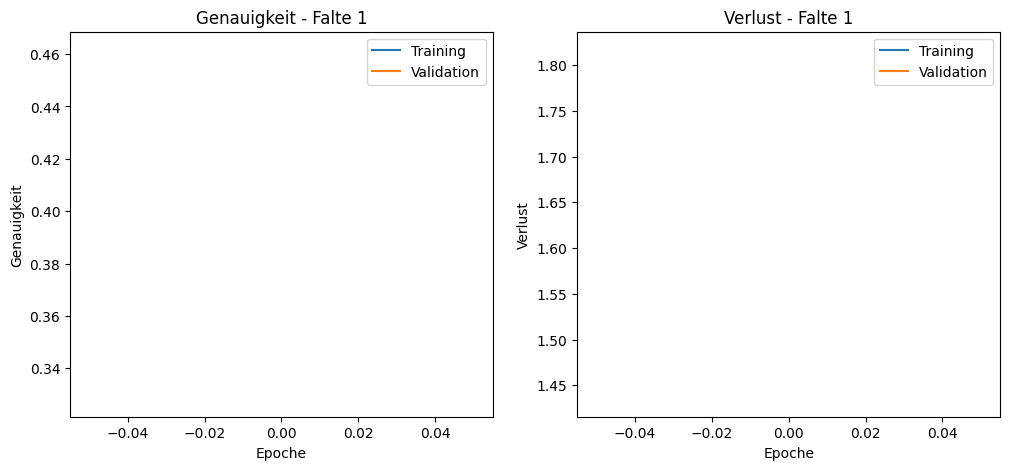

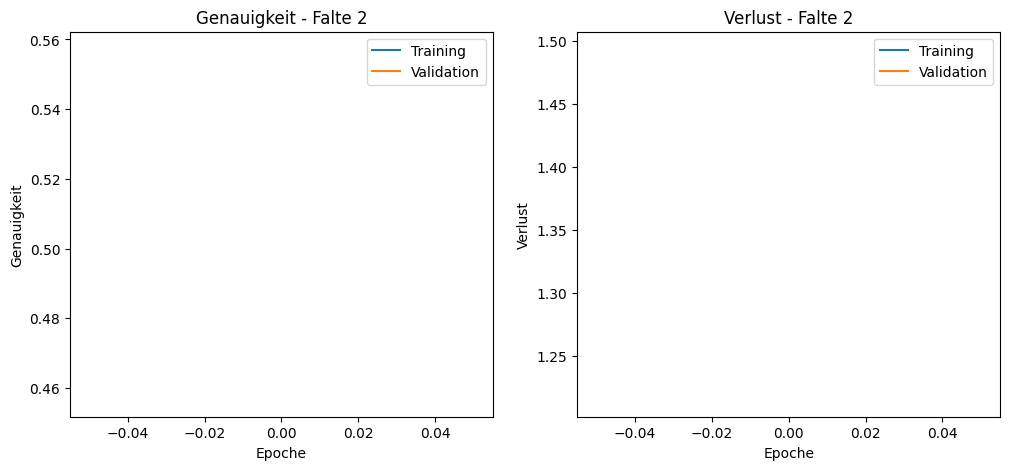

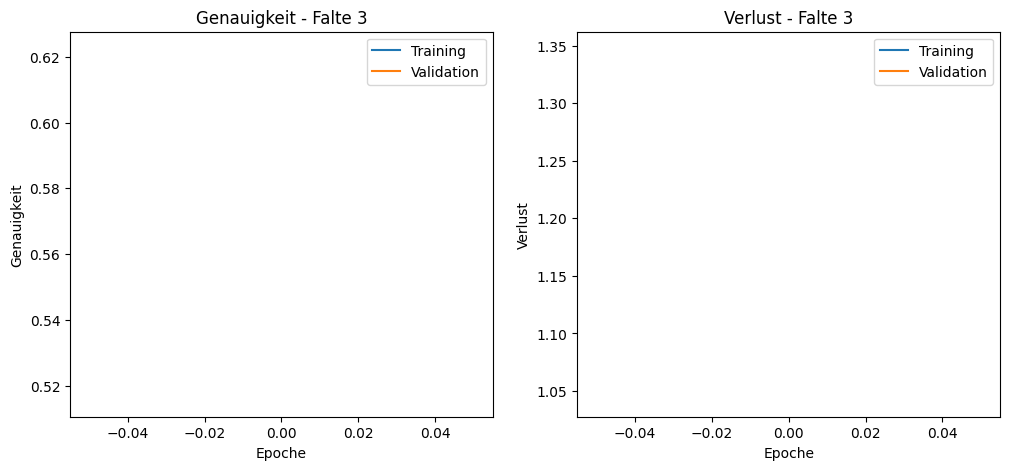

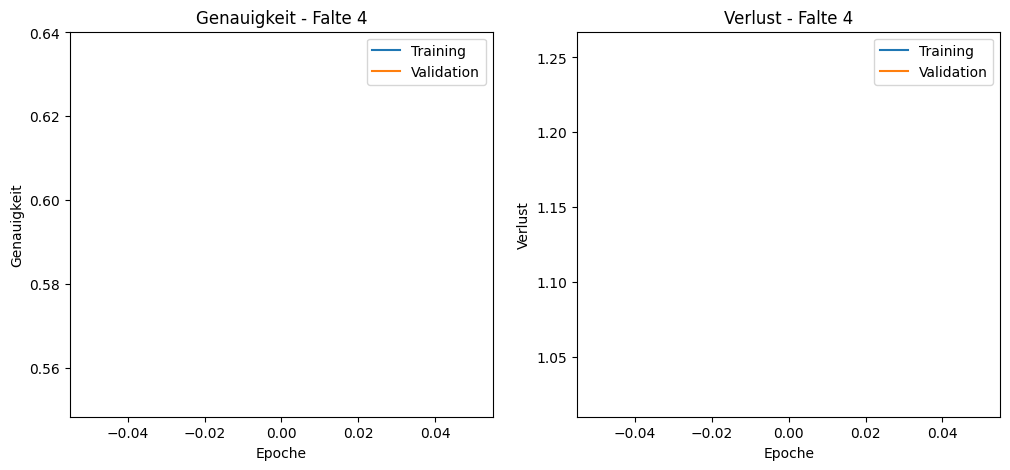

In [52]:
for i, history in enumerate(history_per_fold, start=1):
    plt.figure(figsize=(12, 5))
    
    # Genauigkeit
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Genauigkeit - Falte {i}')
    plt.xlabel('Epoche')
    plt.ylabel('Genauigkeit')
    plt.legend()
    
    # Verlust
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Verlust - Falte {i}')
    plt.xlabel('Epoche')
    plt.ylabel('Verlust')
    plt.legend()
    
    plt.show()




## **Transfer-Learning-Codes mit InceptionV3 mit Imagenet Gewichtung**


**Laden und Vorverarbeiten der Daten**

Der **CIFAR-10-Datensatz** wird geladen und für die Kompatibilität mit InceptionV3 angepasst:
   - Die Originalbilder (32x32) wurden auf 75x75 Pixel vergrößert.
   - Die Bildwerte wurden auf den Bereich [0, 1] skaliert.
   - Die Labels wurden in One-Hot-Form umgewandelt, um mit der Softmax-Ausgangsschicht kompatibel zu sein.
   - 75% der Trainingsdaten wurden für das Training und 20% für die Validierung verwendet.


In [53]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

# Resize images to 75x75
X_train = tf.image.resize(X_train, (75, 75)).numpy()
X_test = tf.image.resize(X_test, (75, 75)).numpy()

# Normalize images to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

# Split training data for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)


**Laden des vortrainierten InceptionV3-Modells**
Dieser Code implementiert ein Modell zur Klassifikation des CIFAR-10-Datensatzes mithilfe des vortrainierten InceptionV3-Modells.

1. **Basismodell: InceptionV3**

- **InceptionV3**: Vortrainiertes Modell auf ImageNet zur Merkmalextraktion.
- Parameter:
  - `weights='imagenet'`: Vortrainierte Gewichte.
  - `include_top=False`: Entfernt Klassifikationsschichten.
  - `input_shape=(75, 75, 3)`: Eingabebilder in 75x75 RGB.

- Gefrorene Gewichte bewahren vortrainierte Merkmale und sparen Rechenaufwand.

2. **Erweiterung des Modells**
Das Modell wird um folgende Schichten ergänzt:

- **GlobalAveragePooling2D**: Verdichtet die Merkmalskarten.
- **Dense(1024)**: Vollverbundene Schicht mit ReLU.
- **Dropout(0.25)**: Verhindert Überanpassung.
- **Dense(10)**: Softmax-Ausgabe für 10 Klassen von CIFAR-10.

3. **Kompilierung des Modells**
Beim Kompilieren werden auch die selben parameter verwendet wie vom eigenem Modell
- **Optimizer**: Adam mit adaptiver Lernrate.
- **Loss**: `categorical_crossentropy` für mehrklassige Probleme.
- **Metrics**: Genauigkeit zur Leistungsbewertung.



In [54]:
# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,911,210 (91.21 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Es wurden die selben Callbacks verwendet, die auch für das eigene Modell verwendet werden.
Auch die Parameter sind unverändert.

**Gegenüberstellung vom eigenen Modell und inspectV3**
Eigentlich sollte das InceptionV3 besser sein. Da das Trainieren mit dem Model lange dauert, können wir leider nicht herausfinden, warum es nicht besser ist.
- **Transfer Learning** mit InceptionV3 liefert bessere Ergebnisse als ein von Grund auf trainiertes Modell.
- **Vorteile**:
  - Schnellere Konvergenz dank vortrainierter Gewichte.
  - Höhere Genauigkeit durch die Nutzung von ImageNet-Merkmalen.
- **Nachteile**:
  - Höhere Speicher- und Rechenanforderungen.

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 125s 203ms/step - accuracy: 0.4695 - loss: 1.5701 - val_accuracy: 0.6010 - val_loss: 1.1442 - learning_rate: 0.0010
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 111s 189ms/step - accuracy: 0.6159 - loss: 1.0938 - val_accuracy: 0.6149 - val_loss: 1.1248 - learning_rate: 0.0010
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 113s 192ms/step - accuracy: 0.6540 - loss: 0.9845 - val_accuracy: 0.6335 - val_loss: 1.0626 - learning_rate: 0.0010
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 191ms/step - accuracy: 0.6832 - loss: 0.8952 - val_accuracy: 0.6354 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 115s 197ms/step - accuracy: 0.7151 - loss: 0.8139 - val_accuracy: 0.6363 - val_loss: 1.0670 - learning_rate: 0.0010
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 114s 195ms/step - accuracy: 0.7463 - loss: 0.7207 - val_accuracy: 0.6349 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 191ms/step - accura

**Feintuning des Modells**

**1. Freigabe von Schichten**
- Nur die letzten 50 Schichten werden trainierbar gemacht.
- Frühere Schichten bleiben eingefroren, um vortrainierte Merkmale zu bewahren.

**2. Neukompilierung**
- Lernrate wird reduziert, um vortrainierte Gewichte minimal zu verändern.

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 261ms/step - accuracy: 0.5464 - loss: 2.1833 - val_accuracy: 0.6522 - val_loss: 1.0590 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - accuracy: 0.7397 - loss: 0.7428 - val_accuracy: 0.6889 - val_loss: 1.0057 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.8053 - loss: 0.5502 - val_accuracy: 0.6976 - val_loss: 0.9954 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.8542 - loss: 0.4197 - val_accuracy: 0.7106 - val_loss: 1.0537 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 238ms/step - accuracy: 0.8857 - loss: 0.3250 - val_accuracy: 0.7139 - val_loss: 1.0812 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.9050 - loss: 0.2684 - val_accuracy: 0.7162 - val_loss: 1.1373 - learning_rate: 1.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 - 31s - 98ms/step - accuracy: 0.7327 - loss: 1.6995
Test Loss: 1.6995
Test Accuracy: 73.27%
